In [773]:
%%html
<style>
table {float:left}
</style>

In [774]:
# my python files
import src.analytics as tics
import src.plotting_functions as pltfuncs
import src.transforms as trans
import src.hyp_test as hyp
import src.score_model as sc
import src.roc_curve as roc
import src.run_on_classifier as run



# Imports
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import kendalltau
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [775]:
# On OSX requires brew install coreutils, using gshuf instead of shuf
sample_name = 'data/sample_random_subset.csv'
tics.create_random_samples('data/kddcup.data', 100000, sample_name)

df = trans.read_data(sample_name)

### Dropping Features


**Highly Correlated Features**

In [776]:
df = trans.drop_high_correlations(df)
trans.drop_zeros_columns(df)

dropped num_compromised
dropped srv_serror_rate
dropped dst_host_serror_rate
dropped serror_rate
dropped dst_host_srv_serror_rate
dropped rerror_rate
dropped dst_host_rerror_rate
dropped dst_host_srv_rerror_rate
dropped dst_host_srv_count
dropped srv_count
dropped dst_host_same_srv_rate
dropped count
dropped hot
dropped dst_host_same_src_port_rate
dropped root_shell
dropped same_srv_rate
dropped urgent
dropped num_outbound_cmds
dropped is_host_login


#### Dropping irrelevant features
Considering that lasso is determining what features to keep (below), I decided to drop the suggested keepers until I get to a point where my logistic regression fails adequately.  This is an attempt to discern which features are derived

#### Then, trimming down a bit at a time

In [782]:
# # Uncomment to get a list of objects
# df_types = tics.get_dict_of_dtypes(df)
# objects = df_dtypes['object']
# objects
column_list = list(df.columns)





#--------------------------------------------#
     Running classifier on ['duration']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    20644
0    20644
Name: attack_category, dtype: int64


True Positives: 4093
True Negatives: 314
False Positives: 3851
True Negatives: 0

Accuracy: 0.533664325502543
Classification_error: 0.466335674497457
Recall: 1.0
Precision: 0.5152316213494461

confusion matrix
[[ 314 3851]
 [   0 4093]]




#--------------------------------------------#
     Running classifier on ['protocol_type']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    20644
0    20644
Name: attack_category, dtype: int64


True Positives: 3008
True Negatives: 3999
False Positives: 101
True Negatives: 1150

Accuracy: 0.8485105352385566
Classification_error: 0.15148946476144345
Recall: 0.7234247234247234
Precision: 0.9675136699903506

confusion matrix
[[3999  101]
 [1150 3008]]




#-------------------------------

/Users/tbot/Dropbox/0_galvanize/0_TODAY/Analyzing-Network-Traffic_kdd99/src/plotting_functions.py:123: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)




Modified Y to balance 1s and 0s
1    20644
0    20644
Name: attack_category, dtype: int64


True Positives: 4105
True Negatives: 2730
False Positives: 1421
True Negatives: 2

Accuracy: 0.8276822475175587
Classification_error: 0.17231775248244127
Recall: 0.9995130265400536
Precision: 0.7428519724936663

confusion matrix
[[2730 1421]
 [   2 4105]]




#--------------------------------------------#
     Running classifier on ['land']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    20644
0    20644
Name: attack_category, dtype: int64


True Positives: 4079
True Negatives: 0
False Positives: 4179
True Negatives: 0

Accuracy: 0.49394526519738435
Classification_error: 0.5060547348026156
Recall: 1.0
Precision: 0.49394526519738435

confusion matrix
[[   0 4179]
 [   0 4079]]




#--------------------------------------------#
     Running classifier on ['wrong_fragment']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    



Modified Y to balance 1s and 0s
1    20644
0    20644
Name: attack_category, dtype: int64


ValueError: Found array with 0 feature(s) (shape=(33030, 0)) while a minimum of 1 is required by StandardScaler.

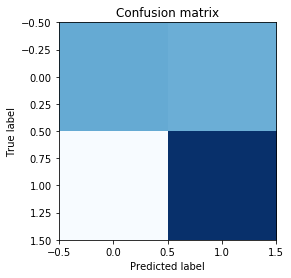

In [787]:
for col in column_list:
    keep = [col]

    # logistic regression object
    classifier = LogisticRegression(penalty='l1')

    run.run_classifier(df, keep, classifier)

# df = trans.drop_all_except(df, keep)



In [763]:
# title = 'Correlation Matrix of data after Dropping Correlated'
# pltfuncs.corr_heat(df, title)

# df.columns
df.columns

Index(['protocol_type', 'label'], dtype='object')

In [741]:
# df.columns
# g = sns.pairplot(df)

### Modeling
#### First try to get a simple logistic regression model working
- steps to get there
    - transform Label into its attack_category
    - transform attack_category into only DOS (2), the rest zero, as DOS is the most prevalent type
    - balance the data set by undersampling the more represented y

In [742]:
# # read in label names csv and send it as dictionary to mapping function
# label_names = ['label', 'attack_category', 'attack_cat_num']
# labels_loc = 'data/categories.csv'
# labels_to_categories = pd.read_csv(labels_loc, header=None)
# labels_to_categories.columns = label_names
# col_name = 'label'
# new_col_name = 'attack_category'

# df = trans.rewrite_values(df, dict(zip(labels_to_categories.label, labels_to_categories.attack_cat_num)), col_name, new_col_name)
# df['attack_category'].value_counts()

2    79235
0    19900
1      827
4       36
3        2
Name: attack_category, dtype: int64

In [743]:
# # rewrite all except attack_category types 2 to zero, put to new dataframe
# df = trans.rewrite_category2_to_zeros(df)
# # df2['attack_category'].value_counts()
# df.head()

,protocol_type,label,attack_category
0,icmp,smurf.,1
1,icmp,smurf.,1
2,tcp,neptune.,1
3,icmp,smurf.,1
4,icmp,smurf.,1


In [744]:
# df = trans.split_to_5050(df)
# df['attack_category'].value_counts()


removed 58470 rows


1    20765
0    20765
Name: attack_category, dtype: int64

In [697]:
# # drop label BEFORE running get dummies on data
# drop_if_in(df, 'label')
# 'label' in df

dropped label


False

In [698]:
# # if 'protocol_type' in df:
# df = pd.get_dummies(df)
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41932 entries, 75969 to 66253
Data columns (total 4 columns):
attack_category       41932 non-null int64
protocol_type_icmp    41932 non-null uint8
protocol_type_tcp     41932 non-null uint8
protocol_type_udp     41932 non-null uint8
dtypes: int64(1), uint8(3)
memory usage: 778.0 KB


In [699]:
# # Split X and Y
# y = df['attack_category']
# X = df.copy()

# # in order to not throw errors
# if 'attack_category' in X:
#     X.drop(['attack_category'], axis=1, inplace=True)
# if 'label' in X:
#     X.drop(['label'], axis=1, inplace=True)
    


Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp'], dtype='object')

### Attempting logistic regression

In [700]:
# # Split the dataset into the Training set and Test set
# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#
# y_train.sum()
# len(y_train)

In [701]:
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

In [702]:
# from sklearn.linear_model import LogisticRegression

# # logistic regression object
# classifier = LogisticRegression(penalty='l1')

# # teach classifier the correlations betw X_train and y_train
# classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [703]:
# # Predict the Test set results
# y_pred = classifier.predict(X_test) # vector giving prediction of each of the test set observations

True Positives: 3021
True Negatives: 4044
False Positives: 108
True Negatives: 1214

Accuracy: 0.8423751043281269
Classification_error: 0.15762489567187313
Recall: 0.7133412042502951
Precision: 0.965484180249281

confusion matrix
[[4044  108]
 [1214 3021]]


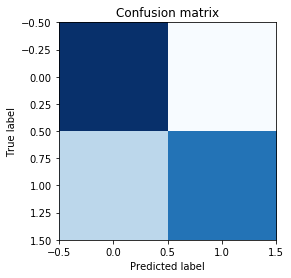

In [704]:
# pltfuncs.my_confusion_matrix(y_test, y_pred)

In [389]:
# lasso = Lasso()
# lasso.fit(X_train, y_train)

# print(lasso)
# print(lasso.coef_)
# # remove 0 coefficients 
# lasso.coef_

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
[ 0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.
  0.  0. -0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.
  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0. -0.
 -0. -0. -0. -0.]


array([ 0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0.])

### Clean up below

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y)


# # scaler = StandardScaler().fit(X_train)
# # X_train_1 = scaler.transform(X_train)
# # X_test_1 = scaler.transform(X_test)

# model = LogisticRegression(class_weight='balanced')
# model.fit(X_train, y_train)
# probabilities = model.predict_proba(X_test)[:, 1]

# # tpr, fpr, thresholds = roc.roc_curve(probabilities, y_test)
# tpr, fpr, thresholds = roc_curve(y_test, probabilities, pos_label=2)

# plt.plot(fpr, tpr)
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity, Recall)")
# plt.title("ROC plot of Logistic Regression Thresholds")
# plt.show()

### Attempting Lasso

In [ ]:
# scaler = StandardScaler()




scorer  = make_scorer(sc.rmsle, greater_is_better=True)

#How to manage many models
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('EN', Ridge())])))

In [ ]:
# results = []
# names = []
# for name, model in pipelines:
#     kfold = KFold(n_splits=3, random_state=21)
#     cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scorer)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
#     plt.plot(cv_results)
# #     plt.xlabel('n')
# #     plt.ylabel('rmse')
# #     plt.title('average test rmse vs sample size n');
    
#     print(msg)

## Run classifier on test data (has new features)

## make series of pairwise plots

## plug in knn